<a href="https://colab.research.google.com/github/keidakira/machine-learning-ucf/blob/main/ML_Homework_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

from sklearn import tree

from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [3]:
# URLs contain the train.csv and test.csv file from the Titanic dataset
train_download = "https://docs.google.com/uc?export=download&id=1SxOK4zcBPL2C0ArlxFyLavnvEjgzjKQ_"
test_download = "https://docs.google.com/uc?export=download&id=1W6Lth3OEjzqyLg5O8U_TCT1oayebB2dE"

!wget -O train.csv --no-check-certificate "$train_download"
!wget -O test.csv --no-check-certificate "$test_download"

train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Store our test passenger IDs for easy access
PassengerId = test_df['PassengerId']

--2021-03-01 02:13:29--  https://docs.google.com/uc?export=download&id=1SxOK4zcBPL2C0ArlxFyLavnvEjgzjKQ_
Resolving docs.google.com (docs.google.com)... 172.217.203.139, 172.217.203.102, 172.217.203.138, ...
Connecting to docs.google.com (docs.google.com)|172.217.203.139|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-00-68-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/srslb3h3sc5vu9c8465fk2efhsr2k91o/1614564750000/16552832296577571015/*/1SxOK4zcBPL2C0ArlxFyLavnvEjgzjKQ_?e=download [following]
--2021-03-01 02:13:29--  https://doc-00-68-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/srslb3h3sc5vu9c8465fk2efhsr2k91o/1614564750000/16552832296577571015/*/1SxOK4zcBPL2C0ArlxFyLavnvEjgzjKQ_?e=download
Resolving doc-00-68-docs.googleusercontent.com (doc-00-68-docs.googleusercontent.com)... 173.194.217.132, 2607:f8b0:400c:c13::84
Connecting to doc-00-68-docs.googleusercontent.com (doc-00

Titanic Data Pre-processing

In [4]:
full_data = [train_df, test_df]

# Feature that tells whether a passenger had a cabin on the Titanic
train_df['Has_Cabin'] = train_df["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test_df['Has_Cabin'] = test_df["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

# Create new feature FamilySize as a combination of SibSp and Parch
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
# Create new feature IsAlone from FamilySize
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
# Remove all NULLS in the Embarked column
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
# Remove all NULLS in the Fare column
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train_df['Fare'].median())

# Remove all NULLS in the Age column
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    # Next line has been improved to avoid warning
    dataset.loc[np.isnan(dataset['Age']), 'Age'] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)

# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
# Group all non-common titles into one single grouping "Rare"
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    # Mapping titles
    title_mapping = {"Mr": 1, "Master": 2, "Mrs": 3, "Miss": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] 						        = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] 							        = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age'] 					       = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] ;

In [5]:
# Feature selection: remove variables no longer containing relevant information
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train_df = train_df.drop(drop_elements, axis = 1)
test_df  = test_df.drop(drop_elements, axis = 1)

In [6]:
def get_gini_impurity(survived_count, total_count):
    survival_prob = survived_count/total_count
    not_survival_prob = (1 - survival_prob)
    random_observation_survived_prob = survival_prob
    random_observation_not_survived_prob = (1 - random_observation_survived_prob)
    mislabelling_survided_prob = not_survival_prob * random_observation_survived_prob
    mislabelling_not_survided_prob = survival_prob * random_observation_not_survived_prob
    gini_impurity = mislabelling_survided_prob + mislabelling_not_survided_prob
    return gini_impurity

In [7]:
# Gini Impurity of starting node
gini_impurity_starting_node = get_gini_impurity(342, 891)
gini_impurity_starting_node

0.47301295786144265

In [8]:
f = train_df.drop("Survived", axis=1)
t = train_df["Survived"]

X_train, X_test, y_train, y_test = train_test_split(f,t,test_size=0.3,random_state=1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((623, 10), (268, 10), (623,), (268,))

In [9]:
f = train_df.drop("Survived",axis=1)
t = train_df["Survived"]
X_train,X_test,y_train,y_test = train_test_split(f,t,test_size=0.3,random_state=1)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((623, 10), (268, 10), (623,), (268,))



---



Task 2 Code

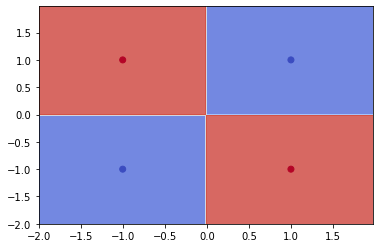

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets

# import some data to play with
iris = datasets.load_iris()
X = np.array([
    [-1, -1],
    [-1, 1],
    [1, -1],
    [1, 1]
])

y = np.array([0, 1, 1, 0])

h = .02  # step size in the mesh

C = 1.0  # SVM regularization parameter
svc = svm.SVC(kernel='linear', C=C).fit(X, y)
rbf_svc = svm.SVC(kernel='rbf', gamma=0.7, C=C).fit(X, y)
poly_svc = svm.SVC(kernel='poly', degree=2, C=C).fit(X, y)
lin_svc = svm.LinearSVC(C=C).fit(X, y)

# create a mesh to plot in
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# title for the plots
titles = ['SVC with linear kernel',
          'LinearSVC (linear kernel)',
          'SVC with RBF kernel',
          'SVC with polynomial (degree 3) kernel']


for i, clf in enumerate((svc, lin_svc, rbf_svc, poly_svc)):
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    if clf != poly_svc:
        continue
    # plt.subplot(2, 2, i + 1)
    # plt.subplots_adjust(wspace=0.4, hspace=0.4)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm)

    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    # plt.title(titles[i])

plt.show()

Task 5 Code

0.0


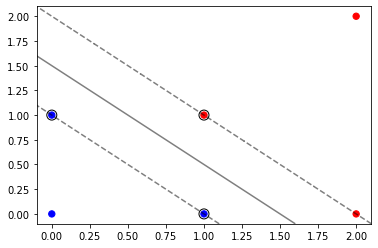

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.datasets import make_blobs


# we create 40 separable points
X = np.array([
    [1, 1],
    [2, 2],
    [2, 0],
    [0, 0],
    [1, 0],
    [0, 1]
])

y = np.array([1, 1, 1, 0, 0, 0])

# fit the model, don't regularize for illustration purposes
clf = svm.SVC(kernel='linear', C=1000)
clf.fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=['red', 'red', 'red', 'blue', 'blue', 'blue'], s=40, cmap=plt.cm.Paired)

# plot the decision function
ax = plt.gca()

xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)

# get the separating hyperplane
w = clf.coef_[0]
a = -w[0] / w[1]
print(clf.coef0)
# plot decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])
# plot support vectors
ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='none', edgecolors='k')
plt.show()

Task 6 Code

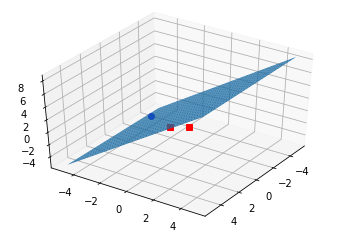

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets

iris = datasets.load_iris()

X = np.array([
  [1, 0, 0],
  [1, -1*np.sqrt(2), 1],
  [1, np.sqrt(2), 1]
])

Y = np.array([1, 0, 1])

X = X[np.logical_or(Y==0,Y==1)]
Y = Y[np.logical_or(Y==0,Y==1)]
model = svm.SVC(kernel='linear')
clf = model.fit(X, Y)
# The equation of the separating plane is given by all x so that np.dot(svc.coef_[0], x) + b = 0.
# Solve for w3 (z)
z = lambda x,y: (-clf.intercept_[0]-clf.coef_[0][0]*x -clf.coef_[0][1]*y) / clf.coef_[0][2]
tmp = np.linspace(-5,5,30)
x,y = np.meshgrid(tmp,tmp)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot3D(X[Y==0,0], X[Y==0,1], X[Y==0,2],'ob')
ax.plot3D(X[Y==1,0], X[Y==1,1], X[Y==1,2],'sr')
ax.plot_surface(x, y, z(x,y))
ax.view_init(41, 34)
plt.show()

Task 7 Code

In [10]:
from sklearn import svm
from sklearn.impute import KNNImputer
from sklearn.model_selection import cross_val_score
clf = svm.SVC(kernel='linear')    # create the new kernel
clf.fit(X_train, y_train.ravel());
accuracy_score = cross_val_score(clf, X_train, y_train.ravel(), cv=5, scoring='accuracy').mean()
print("Accuracy Score for Linear Kernel:", accuracy_score)

Accuracy Score for Linear Kernel: 0.7993935483870966


In [11]:
clf = svm.SVC(kernel='poly', degree=2)
clf.fit(X_train, y_train.ravel());
accuracy_score = cross_val_score(clf, X_train, y_train.ravel(), cv=5, scoring='accuracy').mean()
print("Accuracy Score for Quadratic Kernel:", accuracy_score)

Accuracy Score for Quadratic Kernel: 0.7864516129032257


In [12]:
clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train.ravel());

# Calculate the accuracy using cross-validation.
accuracy_score = cross_val_score(clf, X_train, y_train.ravel(), cv=5, scoring='accuracy').mean()
print("Accuracy Score for RBF Kernel:", accuracy_score)

Accuracy Score for RBF Kernel: 0.8009161290322581
